**Requirements:**
* Trained models

**Outputs:** 
* none 
___
# Imports

In [1]:
import matplotlib
import umap.plot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sn

from utils import load_config, load_dataset, load_smiles, load_model, compute_drug_embeddings, compute_pred

matplotlib.style.use("fivethirtyeight")
matplotlib.style.use("seaborn-talk")
matplotlib.rcParams['font.family'] = "monospace"
matplotlib.rcParams['figure.dpi'] = 60
matplotlib.pyplot.rcParams['savefig.facecolor'] = 'white'
sn.set_context("poster")

[Using backend: pytorch
11:55:36] /opt/dgl/src/runtime/tensordispatch.cc:43: TensorDispatcher: dlopen failed: /home/icb/leon.hetzel/miniconda3/envs/chemical_CPA/lib/python3.7/site-packages/dgl/tensoradapter/pytorch/libtensoradapter_pytorch_1.10.1.so: cannot open shared object file: No such file or directory


In [2]:
%load_ext autoreload
%autoreload 2

## Plotting function

In [138]:
def plot_umap(mapper,
              canon_smiles_unique_sorted, 
              smiles_to_pathway_map, 
              smiles_to_drug_map,
              groups=["Epigenetic regulation", "Tyrosine kinase signaling", "Cell cycle regulation"],
              ood_drugs = []
             ): 
    # important to use the same ordering of SMILES as was used for getting the embedding!
    fig, ax = plt.subplots(figsize=(12,8))
    
    # groups=["Tyrosine kinase signaling"]
    pathway = []
    drugs = []

    for s in canon_smiles_unique_sorted:
        if s in smiles_to_pathway_map: 
            pathway.append(smiles_to_pathway_map[s])
            drugs.append(smiles_to_drug_map[s])
        else: 
            pathway.append('other')
            drugs.append('unknown')
    
    pathway = np.where(pd.Series(pathway).isin(groups), pathway, "other")
    
    cmap = [(0.7,0.7,0.7)]
    cmap.extend(list(plt.get_cmap('tab20').colors))
    cmap = tuple(cmap)

    sn.scatterplot(x=mapper[:,0], y=mapper[:,1], hue=pathway, palette=cmap, ax=ax)
    
    shift = 0.05
    for i, label in enumerate(drugs):
        if drugs[i] in ood_drugs: 
            ax.text(x=mapper[i,0]+shift, y=mapper[i,1]+shift,s=label,fontdict=dict(color='black', alpha=0.5, size=6))
    bbox = (1, 1)

    plt.legend(bbox_to_anchor=bbox)


# Load and analyse model 
* Define `seml_collection` and `model_hash` to load data and model

In [157]:
seml_collection = "finetuning_num_genes"

model_hash_pretrained = "70290e4f42ac4cb19246fafa0b75ccb6" # "config.model.load_pretrained": true, 
model_hash_scratch = "ed3bc586a5fcfe3c4dbb0157cd67d0d9" # "config.model.load_pretrained": false,

___
## Pretrained model

### Load model

In [69]:
# config = load_config(seml_collection, model_hash_pretrained)
# dataset_, key_dict = load_dataset(config)
# config['dataset']['n_vars'] = dataset.n_vars
# canon_smiles_unique_sorted, smiles_to_pathway_map, smiles_to_drug_map = load_smiles(config, dataset_, key_dict, True)
# model_pretrained, embedding_pretrained = load_model(config, canon_smiles_unique_sorted)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

#### Define which drugs should be annotaded with list `ood_drugs`

In [6]:
ood_drugs = dataset.obs.condition[dataset.obs.split_ho_pathway.isin(['ood'])].unique().to_list()

#### Get pathway level 2 annotation for clustering of drug embeddings

In [7]:
smiles_to_pw_level2_map = {}
pw1_to_pw2 = {}

for (drug, pw1, pw2), df in dataset.obs.groupby(['SMILES', 'pathway_level_1', 'pathway_level_2']): 
    smiles_to_pw_level2_map[drug] = pw2
    if pw1 in pw1_to_pw2:
        pw1_to_pw2[pw1].add(pw2)
    else: 
        pw1_to_pw2[pw1] = {pw2}

In [8]:
groups = ["Epigenetic regulation"]

groups_pw2 = [pw2 for pw in groups for pw2 in pw1_to_pw2[pw]]
groups_pw2

['Bromodomain',
 'Histone demethylase',
 'DNA methylation',
 'Histone acetylation',
 'Histone deacetylation',
 'Histone methylation']

### Compute UMAP

In [12]:
transf_embeddings_pretrained = compute_drug_embeddings(model_pretrained, embedding_pretrained)
mapper_pretrained = umap.UMAP(n_neighbors=25, min_dist=0.5).fit_transform(transf_embeddings_pretrained)

### Plot UMAP

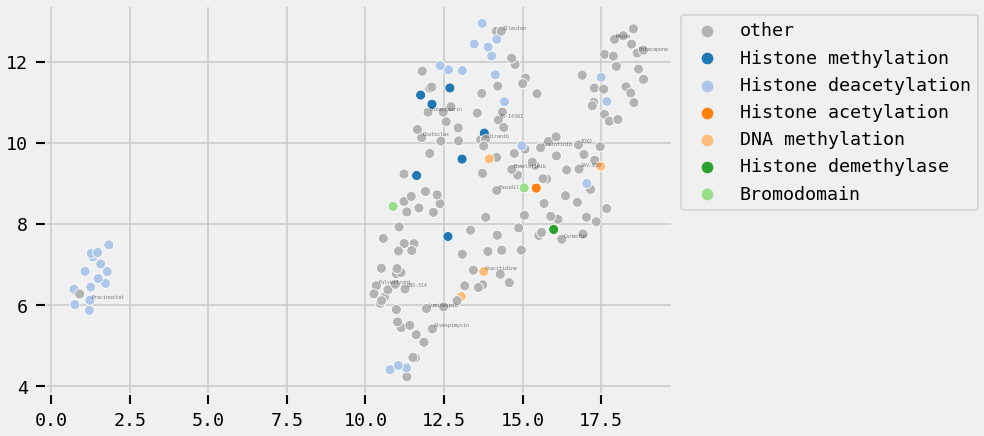

In [13]:
plot_umap(
    mapper_pretrained,
    canon_smiles_unique_sorted, 
    smiles_to_pw_level2_map, 
    smiles_to_drug_map,
    groups = groups_pw2,
    ood_drugs=ood_drugs
)

___
___
## Non-pretrained model

### Load model

In [159]:
config = load_config(seml_collection, model_hash_scratch)
dataset, key_dict = load_dataset(config)
config['dataset']['n_vars'] = dataset.n_vars
canon_smiles_unique_sorted, smiles_to_pathway_map, smiles_to_drug_map = load_smiles(config, dataset, key_dict, return_pathway_map=True)
model_scratch, embedding_scratch = load_model(config, canon_smiles_unique_sorted)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

This model does not contain the covariate embeddings.


### Compute UMAP

In [15]:
transf_embeddings_scratch = compute_drug_embeddings(model_scratch, embedding_scratch)
mapper_scratch = umap.UMAP(n_neighbors=25, min_dist=0.5).fit_transform(transf_embeddings_scratch)

### Plot UMAP

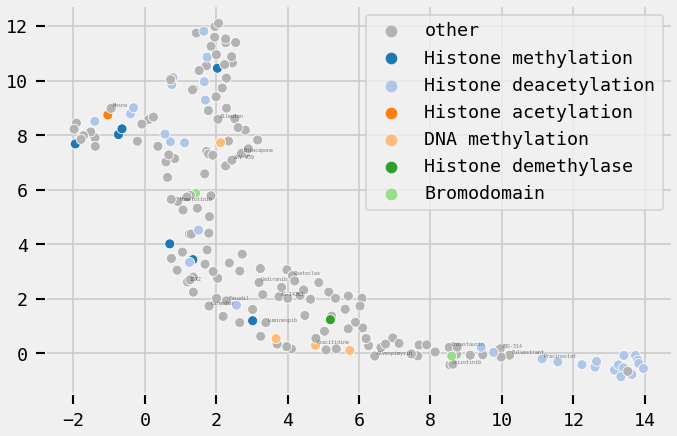

In [16]:
plot_umap(
    mapper_scratch,
    canon_smiles_unique_sorted, 
    smiles_to_pw_level2_map, 
    smiles_to_drug_map,
    groups = groups_pw2,
    ood_drugs=ood_drugs
)

In [ ]:
# from compert.data import load_dataset_splits

# data_params = config['dataset']['data_params']
# data_params['split_key'] = 'split_ho_epigenetic'
# datasets = load_dataset_splits(**data_params, return_dataset=False)

In [ ]:
# datasets

In [ ]:
# predictions_dict = compute_pred(model, datasets['training'])

In [ ]:
# predictions_dict = compute_pred(model, datasets['ood']) # non-pretrained

In [29]:
dataset.obs_names.isin(adata_lincs_small.obs_names).sum()

0

0         REP.A001_A375_24H_X1_B22:B13-2
1         REP.A001_A375_24H_X1_B22:B14-2
2         REP.A001_A375_24H_X1_B22:B15-2
3         REP.A001_A375_24H_X1_B22:B16-2
4         REP.A001_A375_24H_X1_B22:B17-2
                       ...              
199615      PCLB003_PC3_24H_X3_B13:A04-1
199616      PCLB003_PC3_24H_X3_B13:A05-1
199617      PCLB003_PC3_24H_X3_B13:A06-1
199618      PCLB003_PC3_24H_X3_B13:B04-1
199619      PCLB003_PC3_24H_X3_B13:B05-1
Length: 199620, dtype: object

In [56]:
cond = pd.Series(canon_smiles_unique_sorted).isin(smiles_subset)

### Plot UMAP

<AxesSubplot:>

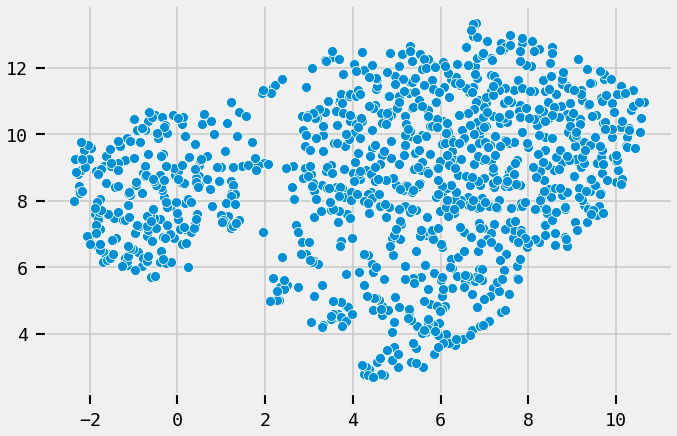

In [84]:
# plot_umap(
#     mapper_pretrained,
#     canon_smiles_unique_sorted, 
#     smiles_to_pw_level2_map, 
#     smiles_to_drug_map,
#     groups = groups_pw2,
#     ood_drugs=ood_drugs
# )

fig, ax = plt.subplots(figsize=(12,8))

# drugs = [smiles_to_drug_map[s] for s in canon_smiles_unique_sorted if smiles_to_drug_map[s]]
# pathway = np.where(pd.Series(pathway).isin(groups), pathway, "other")

# cmap = [(0.7,0.7,0.7)]
# cmap.extend(list(plt.get_cmap('tab20').colors))
# cmap = tuple(cmap)
sn.scatterplot(x=mapper_pretrained[:,0], y=mapper_pretrained[:,1], ax=ax)

# shift = 0.05
# for i, label in enumerate(drugs):
#     if drugs[i] in ood_drugs: 
#         ax.text(x=mapper[i,0]+shift, y=mapper[i,1]+shift,s=label,fontdict=dict(color='black', alpha=0.5, size=6))
# bbox = (1, 1)

# plt.legend(bbox_to_anchor=bbox)

____

In [160]:
from compert.paths import PROJECT_DIR
from rdkit import Chem

# rdkit, LINCS 
seml_collection = "lincs_rdkit_hparam"
model_hash_rdkit = "4f061dbfc7af05cf84f06a724b0c8563"
model_hash_grover = "ff420aea264fca7668ecb147f60762a1"

In [161]:
config = load_config(seml_collection, model_hash_grover)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [162]:
# dataset, key_dict = load_dataset(config)

In [163]:
key_dict['perturbation_key'] = "pert_id"
key_dict['smiles_key'] = "canonical_smiles"

In [164]:
config['dataset']['n_vars'] = dataset.n_vars
config["model"]["append_ae_layer"] = False

In [165]:
dataset

AnnData object with n_obs × n_vars = 581777 × 2000
    obs: 'cell_type', 'dose', 'dose_character', 'dose_pattern', 'g1s_score', 'g2m_score', 'pathway', 'pathway_level_1', 'pathway_level_2', 'product_dose', 'product_name', 'proliferation_index', 'replicate', 'size_factor', 'target', 'vehicle', 'batch', 'n_counts', 'dose_val', 'condition', 'drug_dose_name', 'cov_drug_dose_name', 'cov_drug', 'control', 'split_ho_pathway', 'split_tyrosine_ood', 'split_epigenetic_ood', 'split_cellcycle_ood', 'SMILES', 'split_ood_finetuning', 'split_ho_epigenetic', 'split_ho_epigenetic_all', 'split_random'
    var: 'id', 'num_cells_expressed-0-0', 'num_cells_expressed-1-0', 'num_cells_expressed-1', 'gene_id', 'in_lincs', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'all_DEGs', 'hvg', 'lincs_DEGs', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [166]:
# canon_smiles_unique_sorted, smiles_to_drug_map = load_smiles(config, dataset, key_dict)

In [168]:
adata_lincs_small = sc.read(PROJECT_DIR/'datasets'/'lincs_small_.h5ad') if adata_lincs_small is None else adata_lincs_small

# obs_lincs_small = pd.Series(adata_lincs_small.obs.index).apply(lambda x: "-".join(x.split("-")[:-1]))
# smiles_subset = dataset.obs.loc[dataset.obs_names.isin(obs_lincs_small), 'canonical_smiles'].unique().to_list()
# smiles_subset = [Chem.CanonSmiles(s) for s in smiles_subset]

In [171]:
smiles_list = list(set(canon_smiles_unique_sorted + smiles_subset))
model_pretrained, embedding_pretrained = load_model(config, smiles_list)

This model does not contain the covariate embeddings.


In [190]:
transf_embeddings_pretrained = compute_drug_embeddings(model_pretrained, embedding_pretrained)#[cond]

mapper_pretrained = umap.UMAP(n_neighbors=15, min_dist=0.1).fit_transform(transf_embeddings_pretrained)

In [191]:
sciplex_drugs = dataset_.obs.condition.unique().to_list()

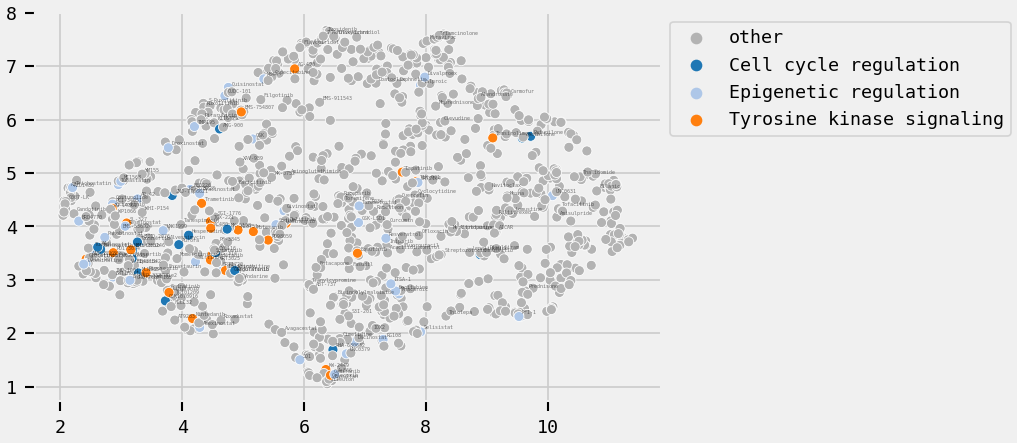

In [192]:
plot_umap(
    mapper_pretrained,
    smiles_list, 
    smiles_to_pathway_map, 
    smiles_to_drug_map,
#     groups = groups_pw2,
    ood_drugs=sciplex_drugs
)